In [258]:
import math
# in all of the backward passes the gradients are added because when a vairable is used more than once if the grads are not added , then it is just reassigned leading to 
#inaccuracy in backpropogation 
class value:
    def __init__(self,data,_children=(),_op='',label='') :
        self.data=data
        self._prev = set(_children)
        self._op = _op
        self.label=label
        self._backward=lambda :None
        self.grad=0
    def __repr__(self) -> str:
        return f"Value (data={self.data})"
    
    def __add__(self,other):
        other=other if isinstance(other,value) else value(other)
        out= value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        return out
    
    def __radd__(self,other):
        return self+ other
    
    def __mul__(self,other):
        other=other if isinstance(other,value) else value(other)# we are writing this code because if we add any int to the value object it will wrap it in value and then give the result thereby not throwing a error
        out= value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad+= other.data * out.grad
            other.grad +=self.data* out.grad
        out._backward=_backward
        return out
    
    def __rmul__(self,other):
        return self* other
    
    def __neg__(self):
        return self *-1
    
    def __sub__(self,other):
        return self +(-other)
    
    def __truediv__(self,other):
        return self*other**-1
    
    def __pow__(self,other):
        assert isinstance(other ,(int,float))
        out=value(self.data**other, (self,),f'**{other}')

        def _backward():
            self.grad+= other*(self.data **(other-1))*out.grad
        out._backward=_backward
        return out
    
    def exp(self):
        x=self.data
        out=value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad=out.data*out.grad# it is because the differnciation of e^x is itself which we have calculated in out so out.data
        out._backward=_backward
        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)  
        out=value(t,(self,),'tanh')
        def _backward():
            self.grad= (1 - t**2) * out.grad 
        out._backward=_backward
        return out  
    
    def backward(self):
        topo=[]#this will contain the list of neurons in topological order as we need it to compute backpropogation
        visited=set()
        def build_topo(v):
            if v not in visited :
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0# we need to initialize this to zero because only from here we are starting and in the value class we have initialized the grad to 0 so it will
# always return 0 if we dont initialize
        for node in reversed(topo):
            node._backward()


In [259]:
a=value(2,label='a')
b=value(4,label='b')
c=value(10,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=value(-2,label='f')
L=d*f ; L.label="L"

In [260]:
a/b

Value (data=0.5)

In [261]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    # assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid=str(id(n))
        dot.node(name= uid, label = "{ %s|data %.4f|grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

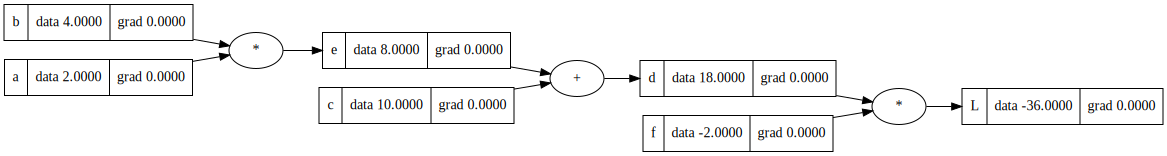

In [262]:
draw_dot(L)

L=d*f
dL/dd=f therefore grad of d will be the value of f

you can numerically verify all the grad by changing the data part of the node by h and then calculating L2-L1/h

d=c+e
dd/dc=1 therefore
dL/dc=(dL/dd)*(dd/dc)
=-2*1=-2
similar for e

e=a*b
de/da=b ; dL/da=dL/de * de/da =-2*-3=6



In [263]:
L.grad=1
d.grad=-2
f.grad=4
c.grad=-2
e.grad=-2
a.grad=6
b.grad=-4

In [264]:
def lol():
    h=0.001
    a=value(2,label='a')
    b=value(-3,label='b')
    c=value(10,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=value(-2,label='f')
    L=d*f ; L.label="L"
    L1=L.data

    a=value(2,label='a')
    b=value(-3+h,label='b')
    c=value(10,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=value(-2,label='f')
    L=d*f ; L.label="L"
    L2=L.data

    print((L2-L1)/h)
lol()



-3.9999999999995595


In [265]:
#second example # inputs
x1=value(2.0,label='x1')
x2=value(0.0,label='x2')
#weights
w1=value(-3.0,label='w1')
w2=value(1.0,label='w2')
#bias of the neuron
b=value(6.881373587,label='b')
x1w1=x1*w1 ; x1w1.label='x1w1'
x2w2=x2*w2 ; x2w2.label='x2w2'
x1w1x2w2=x1w1+x2w2 ; x1w1x2w2.label='x1w1 + x2w2'
n=x1w1x2w2 +b ; n.label ='n'
e=(2*n).exp()
o=(e-1)/(e+1);o.label='o'
o.backward()
# o=n.tanh();o.label='o'



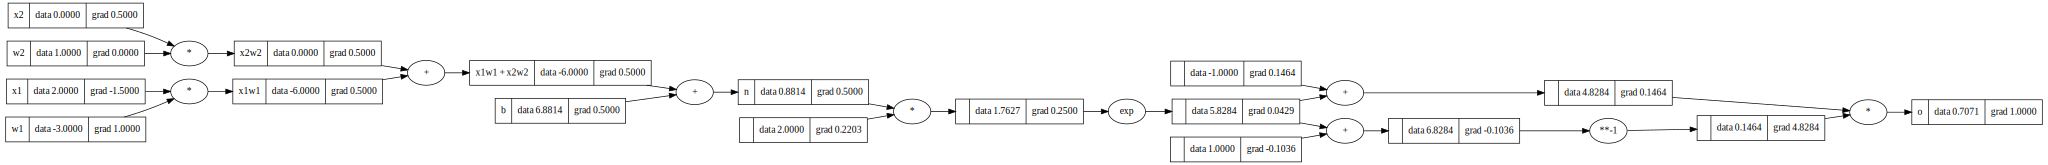

In [266]:
draw_dot(o)

In [196]:
o.backward()

do/dn=d/dn(tanh)=1-tanh(n)**2
=1-0.707**2=0.5
d0/dw1=do/dw1x1 *x1.data=0.5*2=1
dx1=-1.5


In [270]:
import torch
x1=torch.Tensor([2.0]).double()   ;x1.requires_grad=True
x2=torch.Tensor([0.0]).double()   ;x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()   ;w1.requires_grad=True
w2=torch.Tensor([1.0]).double()   ;w2.requires_grad=True
b=torch.Tensor([6.881373587]).double()   ;b.requires_grad=True
n=x1*w1 + x2*w2 +b 
o=torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())





0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [419]:
import random


class Neuron:
    def __init__(self,nin):
        self.w=[value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=value(random.uniform(-1,-1))
    def __call__(self, x):
        act=sum((xi*wi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out
    def parameters(self):
      return self.w + [self.b]

    
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value (data=-0.13223721743383118)

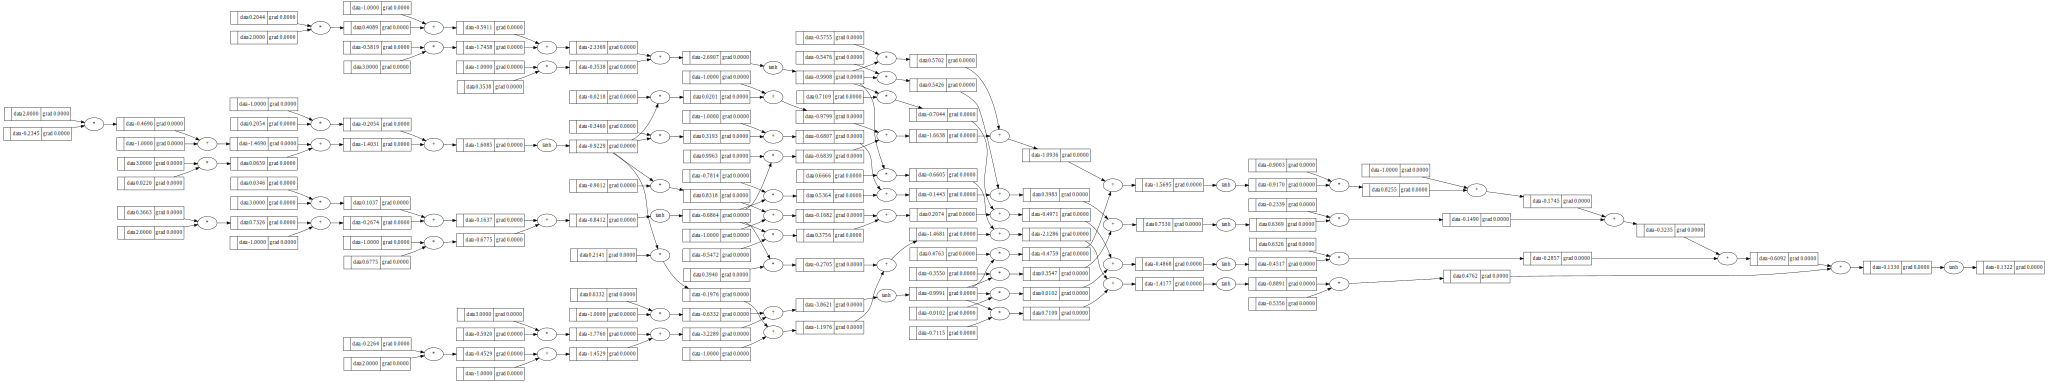

In [420]:
draw_dot(n(x))

In [421]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [425]:
for k in range(20):
    y_pred=[n(x) for x in xs]
    floss=sum([(yout-ygt)**2 for ygt,yout in zip(ys,y_pred)])

    for p in n.parameters():
        p.grad=0.0# we need to reset the grad to zero before we start the next forward propogation because the grads could accumulate and cause error 
        # leading to faster convergence in small datasets but it is a bug
    floss.backward()
    for p in n.parameters():
        p.data += -0.05*p.grad

    print(k,floss.data)

0 0.013561703677882385
1 0.013196700708270025
2 0.012850454772148558
3 0.012521566863193499
4 0.012208773141393323
5 0.011910929040505733
6 0.011626995561613725
7 0.011356027410391607
8 0.011097162695555211
9 0.010849613954324445
10 0.010612660309973855
11 0.010385640598556197
12 0.010167947328102988
13 0.009959021355178834
14 0.009758347181484283
15 0.009565448787982836
16 0.009379885936329775
17 0.00920125087766006
18 0.009029165417412211
19 0.008863278292114758


In [423]:
n.parameters()

[Value (data=-0.23801004095398845),
 Value (data=-0.030476509344119766),
 Value (data=0.31219644617775666),
 Value (data=-0.9833075669204163),
 Value (data=0.5486491033793751),
 Value (data=-0.08412737442976399),
 Value (data=1.1808450888790625),
 Value (data=-0.7341808805453105),
 Value (data=0.047881432027258315),
 Value (data=-0.5542738500015771),
 Value (data=0.2784329180596783),
 Value (data=-1.0767426499209607),
 Value (data=-0.2594875055494738),
 Value (data=-0.5641144503300136),
 Value (data=0.6410884792594064),
 Value (data=-0.9989194902593495),
 Value (data=-0.15912612390914466),
 Value (data=1.183946314971967),
 Value (data=-0.6593964762869281),
 Value (data=0.3427211164037339),
 Value (data=-0.7956652956592969),
 Value (data=-0.3460745276546399),
 Value (data=-0.7857161153719292),
 Value (data=-0.5320627014684318),
 Value (data=-0.3503634327900781),
 Value (data=-1.0027675267760106),
 Value (data=-1.0546592116904392),
 Value (data=-0.8744521933680915),
 Value (data=0.455289